# Train Prophet Models for Stock Direction Prediction

## Overview
This notebook trains Prophet models to predict the direction of stock price movements (up/down) for different time horizons:
- Next day direction
- Next week direction
- Next month direction

We'll train 60 models in total (20 stocks × 3 time periods) and evaluate their performance for direction prediction.

## 1. Import Libraries

In [35]:
# Import necessary libraries
import pandas as pd
import numpy as np
import os
import glob
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import concurrent.futures
import time
import warnings

# Prophet-specific imports
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

# Metrics for binary classification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Set display options
pd.set_option('display.max_columns', None)
%matplotlib inline

# Ignore specific warnings from Prophet
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Visualization settings
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

## 2. Setup Directory Structure

In [37]:
# Input directories (where prepared data is stored)
base_input_dir = '../data/prophet/'

# Output directories (where models will be saved)
base_output_dir = '../model/prophet/'

# Create output directories for each prediction period
periods = ['day', 'week', 'month']
input_dirs = {}
output_dirs = {}

for period in periods:
    input_dirs[period] = os.path.join(base_input_dir, period)
    output_dirs[period] = os.path.join(base_output_dir, period)
    os.makedirs(output_dirs[period], exist_ok=True)
    print(f"Created output directory: {output_dirs[period]}")

Created output directory: ../model/prophet/day
Created output directory: ../model/prophet/week
Created output directory: ../model/prophet/month


## 3. Define Helper Functions

### 3.1 Training and Evaluation Functions

In [38]:
def train_prophet_model(df, regressors=None, params=None):
    """
    Train a Prophet model with the specified parameters.
    
    Parameters:
    - df: DataFrame formatted for Prophet (must contain 'ds' and 'y' columns)
    - regressors: List of regressor column names to use for prediction
    - params: Dictionary of Prophet parameters
    
    Returns:
    - Trained Prophet model
    """
    # Set default parameters if none provided
    if params is None:
        params = {
            'changepoint_prior_scale': 0.05,
            'seasonality_prior_scale': 10.0,
            'seasonality_mode': 'additive',
            'daily_seasonality': False,
            'weekly_seasonality': True,
            'yearly_seasonality': True
        }
    
    # Create Prophet model with specified parameters
    model = Prophet(
        changepoint_prior_scale=params.get('changepoint_prior_scale', 0.05),
        seasonality_prior_scale=params.get('seasonality_prior_scale', 10.0),
        seasonality_mode=params.get('seasonality_mode', 'additive'),
        daily_seasonality=params.get('daily_seasonality', False),
        weekly_seasonality=params.get('weekly_seasonality', True),
        yearly_seasonality=params.get('yearly_seasonality', True)
    )
    
    # Add regressors
    if regressors is not None:
        for regressor in regressors:
            if regressor in df.columns:
                model.add_regressor(regressor)
    
    # Fit the model
    model.fit(df)
    
    return model

def evaluate_direction_predictions(y_true, y_pred_proba, threshold=0.5):
    """
    Evaluate binary classification predictions for direction prediction.
    
    Parameters:
    - y_true: True binary labels
    - y_pred_proba: Predicted probabilities
    - threshold: Threshold to convert probabilities to binary predictions (default: 0.5)
    
    Returns:
    - Dictionary of evaluation metrics
    """
    # Convert probabilities to binary predictions
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'confusion_matrix': confusion_matrix(y_true, y_pred),
        'threshold': threshold
    }
    
    # Only calculate ROC AUC if there are both positive and negative classes
    if len(np.unique(y_true)) > 1:
        metrics['roc_auc'] = roc_auc_score(y_true, y_pred_proba)
    
    return metrics

def find_optimal_threshold(y_true, y_pred_proba, metric='f1'):
    """
    Find the optimal threshold for converting probabilities to binary predictions.
    
    Parameters:
    - y_true: True binary labels
    - y_pred_proba: Predicted probabilities
    - metric: Metric to optimize ('accuracy', 'precision', 'recall', 'f1')
    
    Returns:
    - Optimal threshold
    - Dictionary of evaluation metrics at optimal threshold
    """
    # Try different thresholds
    thresholds = np.arange(0.1, 0.9, 0.05)
    best_threshold = 0.5
    best_score = 0
    
    for threshold in thresholds:
        # Convert probabilities to binary predictions
        y_pred = (y_pred_proba >= threshold).astype(int)
        
        # Calculate metric
        if metric == 'accuracy':
            score = accuracy_score(y_true, y_pred)
        elif metric == 'precision':
            score = precision_score(y_true, y_pred, zero_division=0)
        elif metric == 'recall':
            score = recall_score(y_true, y_pred, zero_division=0)
        elif metric == 'f1':
            score = f1_score(y_true, y_pred, zero_division=0)
        else:
            raise ValueError(f"Unknown metric: {metric}")
        
        # Update best threshold if current threshold gives better score
        if score > best_score:
            best_score = score
            best_threshold = threshold
    
    # Evaluate with best threshold
    best_metrics = evaluate_direction_predictions(y_true, y_pred_proba, best_threshold)
    
    return best_threshold, best_metrics

### 3.2 Time-Based Train-Test Split Functions

In [39]:
def time_based_train_test_split(df, test_size=0.2):
    """
    Split time series data into train and test sets based on time.
    
    Parameters:
    - df: DataFrame with a 'ds' datetime column
    - test_size: Proportion of data to use for testing (default: 0.2)
    
    Returns:
    - train_df: Training DataFrame
    - test_df: Testing DataFrame
    """
    # Ensure DataFrame is sorted by date
    df = df.sort_values('ds')
    
    # Calculate split point
    split_idx = int(len(df) * (1 - test_size))
    
    # Split data
    train_df = df.iloc[:split_idx].copy()
    test_df = df.iloc[split_idx:].copy()
    
    return train_df, test_df

def sliding_window_cv(df, n_windows=5, window_size=0.2):
    """
    Generate sliding window splits for time series cross-validation.
    
    Parameters:
    - df: DataFrame with a 'ds' datetime column
    - n_windows: Number of validation windows
    - window_size: Size of each validation window as a proportion of data
    
    Returns:
    - List of (train_df, val_df) tuples
    """
    # Ensure DataFrame is sorted by date
    df = df.sort_values('ds')
    
    # Initialize list to store splits
    splits = []
    
    # Calculate window size in terms of number of samples
    window_samples = int(len(df) * window_size)
    
    # Generate sliding windows
    for i in range(n_windows):
        # Calculate split points
        max_end_idx = len(df) - i * window_samples
        start_idx = max(0, max_end_idx - window_samples)
        end_idx = max_end_idx
        
        # Split data
        train_df = df.iloc[:start_idx].copy()
        val_df = df.iloc[start_idx:end_idx].copy()
        
        # Only add split if we have enough data
        if len(train_df) > 0 and len(val_df) > 0:
            splits.append((train_df, val_df))
    
    return splits

## 4. Model Training Pipeline

In [40]:
def train_and_evaluate_prophet(stock, period, use_cv=True):
    """
    Train and evaluate a Prophet model for a specific stock and period.
    
    Parameters:
    - stock: Stock symbol
    - period: Prediction period ('day', 'week', 'month')
    - use_cv: Whether to use cross-validation (default: True)
    
    Returns:
    - Dictionary containing model, parameters, evaluation metrics, etc.
    """
    # Start timing
    start_time = time.time()
    
    # Define file paths
    input_file = os.path.join(input_dirs[period], f"{stock}_prophet_{period}.csv")
    output_file = os.path.join(output_dirs[period], f"prophet_{stock}_{period}.pkl")
    
    # Check if input file exists
    if not os.path.exists(input_file):
        print(f"Input file not found: {input_file}")
        return None
    
    # Load data
    df = pd.read_csv(input_file)
    df['ds'] = pd.to_datetime(df['ds'])
    
    # Get regressor columns (all numeric columns except 'y' and special columns)
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
    regressors = [col for col in numeric_cols if col != 'y' and col != 'next_day_close' 
                  and col != 'next_week_avg' and col != 'next_month_avg']
    
    # Configure Prophet parameters based on period
    if period == 'day':
        params = {
            'changepoint_prior_scale': 0.05,
            'seasonality_prior_scale': 10.0,
            'seasonality_mode': 'additive',
            'daily_seasonality': False,
            'weekly_seasonality': True,
            'yearly_seasonality': True
        }
    elif period == 'week':
        params = {
            'changepoint_prior_scale': 0.1,
            'seasonality_prior_scale': 10.0,
            'seasonality_mode': 'additive',
            'daily_seasonality': False,
            'weekly_seasonality': False,
            'yearly_seasonality': True
        }
    else:  # month
        params = {
            'changepoint_prior_scale': 0.15,
            'seasonality_prior_scale': 10.0,
            'seasonality_mode': 'additive',
            'daily_seasonality': False,
            'weekly_seasonality': False,
            'yearly_seasonality': True
        }
    
    # Split data into train and test sets
    train_df, test_df = time_based_train_test_split(df, test_size=0.2)
    
    # Train model on all data (for final model)
    model = train_prophet_model(df, regressors=regressors, params=params)
    
    # Train model on training data (for evaluation)
    eval_model = train_prophet_model(train_df, regressors=regressors, params=params)
    
    # Make predictions on test data
    test_features = test_df[['ds'] + regressors].rename(columns={'ds': 'ds'})
    test_predictions = eval_model.predict(test_features)
    
    # Evaluate predictions
    y_true = test_df['y'].values
    y_pred_proba = test_predictions['yhat'].values
    
    # Find optimal threshold
    best_threshold, best_metrics = find_optimal_threshold(y_true, y_pred_proba, metric='f1')
    
    # Evaluate with default threshold for comparison
    default_metrics = evaluate_direction_predictions(y_true, y_pred_proba, threshold=0.5)
    
    # Cross-validation if enabled
    cv_metrics = None
    if use_cv:
        cv_splits = sliding_window_cv(df, n_windows=3, window_size=0.2)
        cv_results = []
        
        for cv_train, cv_val in cv_splits:
            # Train model on this CV split
            cv_model = train_prophet_model(cv_train, regressors=regressors, params=params)
            
            # Make predictions
            cv_features = cv_val[['ds'] + regressors].rename(columns={'ds': 'ds'})
            cv_predictions = cv_model.predict(cv_features)
            
            # Evaluate
            cv_true = cv_val['y'].values
            cv_pred_proba = cv_predictions['yhat'].values
            cv_metrics_fold = evaluate_direction_predictions(cv_true, cv_pred_proba, threshold=best_threshold)
            cv_results.append(cv_metrics_fold)
        
        # Average CV results
        # (Note: cv_metrics was being overwritten in loop, fixed to cv_metrics_fold)
        if cv_results: # Check if cv_results is not empty
            cv_metrics = {
                'accuracy': np.mean([m['accuracy'] for m in cv_results]),
                'precision': np.mean([m['precision'] for m in cv_results]),
                'recall': np.mean([m['recall'] for m in cv_results]),
                'f1': np.mean([m['f1'] for m in cv_results])
            }
            
            if all('roc_auc' in m for m in cv_results if m is not None):
                 # Ensure all results have roc_auc before averaging
                roc_aucs = [m['roc_auc'] for m in cv_results if 'roc_auc' in m]
                if roc_aucs:
                    cv_metrics['roc_auc'] = np.mean(roc_aucs)
    
    # Create results dictionary
    results = {
        'stock': stock,
        'period': period,
        'model': model,
        'params': params,
        'regressors': regressors,
        'train_size': len(train_df),
        'test_size': len(test_df),
        'best_threshold': best_threshold,
        'best_metrics': best_metrics,
        'default_metrics': default_metrics,
        'cv_metrics': cv_metrics,
        'training_time': time.time() - start_time
    }
    
    # Save model
    with open(output_file, 'wb') as f:
        pickle.dump(results, f)
    
    return results

## 5. Test Pipeline with a Single Model

Let's test the pipeline with a single stock and period before training all models:

In [41]:
# Get list of all stock files
all_stocks = set()
for period in periods:
    stock_files = glob.glob(os.path.join(input_dirs[period], "*_prophet_*.csv"))
    for file in stock_files:
        # Extract stock symbol from filename (format: {stock}_prophet_{period}.csv)
        stock = os.path.basename(file).split('_prophet_')[0]
        all_stocks.add(stock)

all_stocks = sorted(list(all_stocks))
print(f"Found {len(all_stocks)} stocks: {', '.join(all_stocks)}")

# Train a model for one stock and period to test the pipeline
test_stock = all_stocks[0]  # First stock in the list
test_period = 'day'  # Start with day prediction

print(f"Testing training pipeline with {test_stock} for {test_period} prediction...")
test_results = train_and_evaluate_prophet(test_stock, test_period, use_cv=True)

if test_results is not None:
    print(f"\nTraining completed in {test_results['training_time']:.2f} seconds")
    print(f"Best threshold: {test_results['best_threshold']:.2f}")
    
    print("\nMetrics with best threshold:")
    for metric, value in test_results['best_metrics'].items():
        if not isinstance(value, np.ndarray):  # Skip confusion matrix
            print(f"  {metric}: {value:.4f}")
    
    print("\nConfusion Matrix:")
    print(test_results['best_metrics']['confusion_matrix'])
    
    if test_results['cv_metrics'] is not None:
        print("\nCross-Validation Metrics:")
        for metric, value in test_results['cv_metrics'].items():
            print(f"  {metric}: {value:.4f}")
else:
    print("Failed to train model for test stock and period.")

18:25:51 - cmdstanpy - INFO - Chain [1] start processing


Found 20 stocks: AAPL, AMD, AMZN, BA, BABA, DIS, GOOG, GS, IBM, INTC, META, MSFT, NFLX, NKE, NVDA, PYPL, SPY, T, TSLA, V
Testing training pipeline with AAPL for day prediction...


18:25:51 - cmdstanpy - INFO - Chain [1] done processing
18:25:52 - cmdstanpy - INFO - Chain [1] start processing
18:25:52 - cmdstanpy - INFO - Chain [1] done processing
18:25:52 - cmdstanpy - INFO - Chain [1] start processing
18:25:52 - cmdstanpy - INFO - Chain [1] done processing
18:25:53 - cmdstanpy - INFO - Chain [1] start processing
18:25:53 - cmdstanpy - INFO - Chain [1] done processing
18:25:53 - cmdstanpy - INFO - Chain [1] start processing
18:25:53 - cmdstanpy - INFO - Chain [1] done processing



Training completed in 2.00 seconds
Best threshold: 0.45

Metrics with best threshold:
  accuracy: 0.5511
  precision: 0.5479
  recall: 0.9926
  f1: 0.7060
  threshold: 0.4500
  roc_auc: 0.4932

Confusion Matrix:
[[  6 222]
 [  2 269]]

Cross-Validation Metrics:
  accuracy: 0.5274
  precision: 0.5307
  recall: 0.9549
  f1: 0.6819
  roc_auc: 0.4949


## 6. Visualize Test Model Results

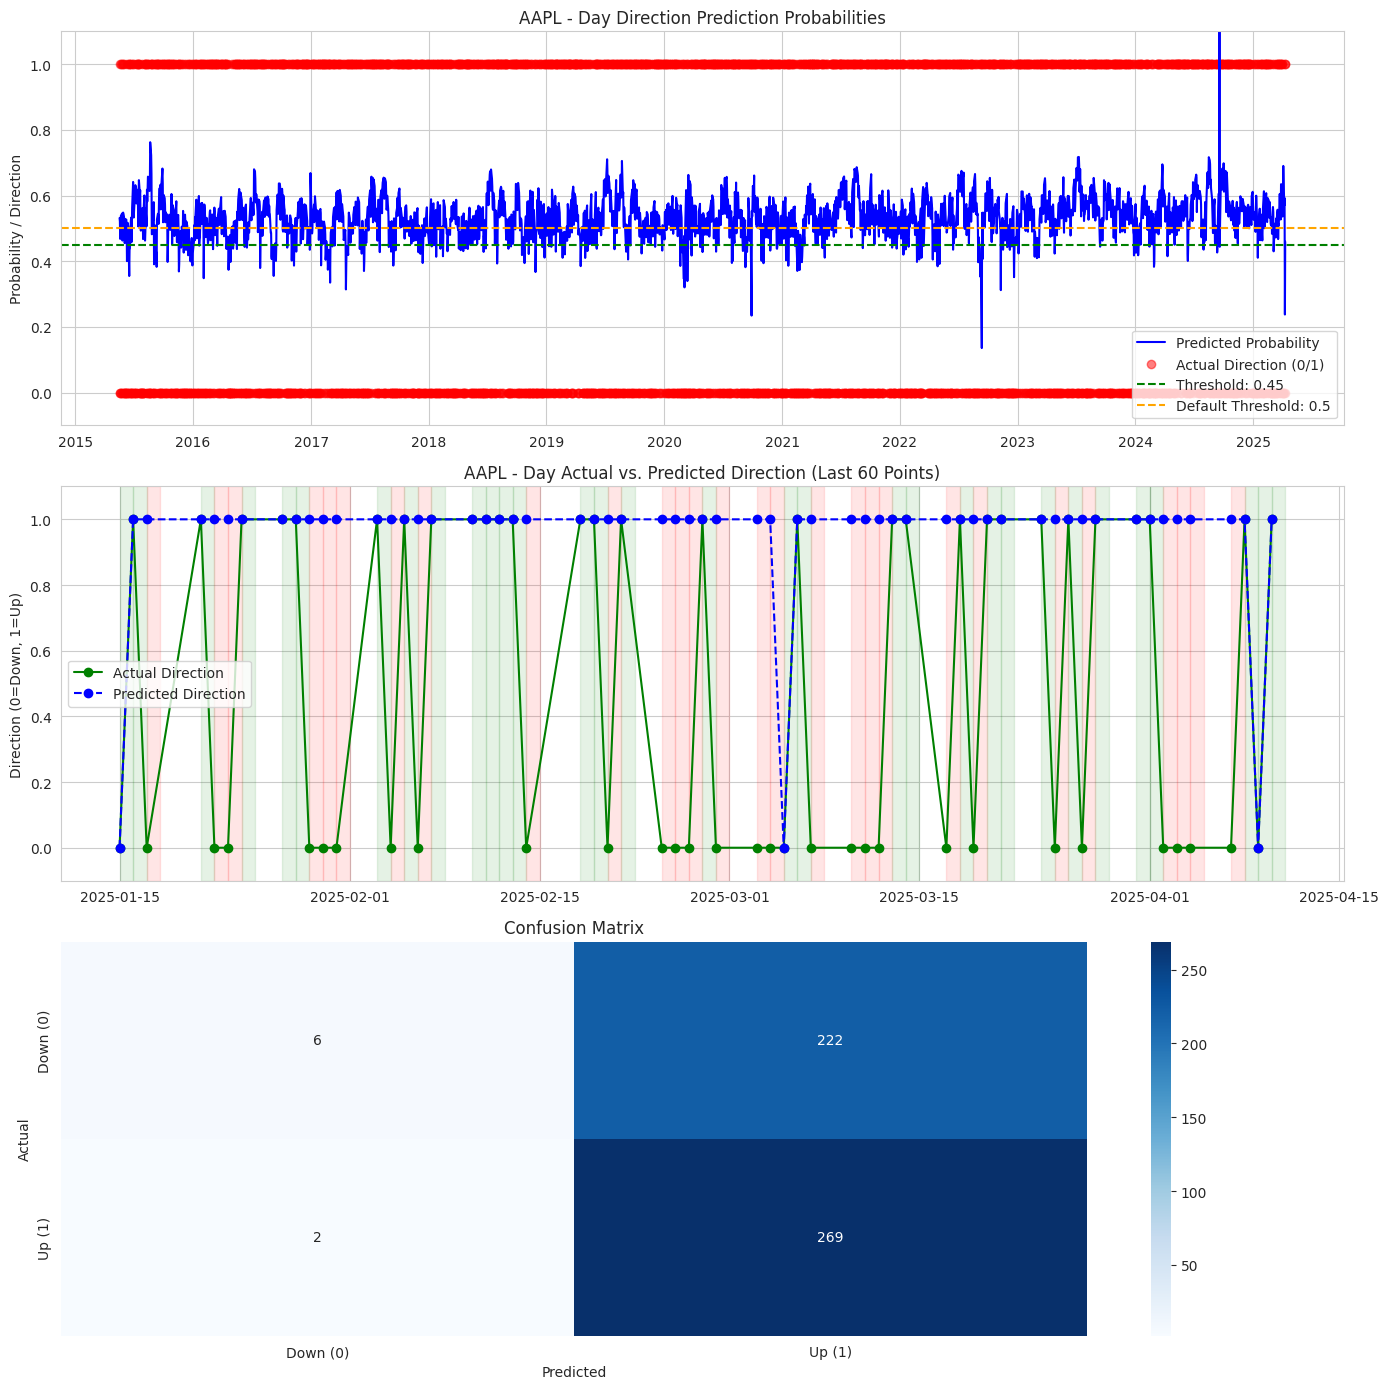


Prediction Statistics for AAPL - Day:
Accuracy: 0.5511
F1 Score: 0.7060
Precision: 0.5479
Recall: 0.9926
ROC AUC: 0.4932

Class Distribution:
Down (0): 47.1%
Up (1): 52.9%


In [42]:
def visualize_model_predictions(stock, period, results=None):
    """
    Visualize Prophet model predictions for direction prediction.
    
    Parameters:
    - stock: Stock symbol
    - period: Prediction period ('day', 'week', 'month')
    - results: Results dictionary from train_and_evaluate_prophet
      If None, will attempt to load from saved file
    """
    if results is None:
        # Try to load from file
        model_file = os.path.join(output_dirs[period], f"prophet_{stock}_{period}.pkl")
        if not os.path.exists(model_file):
            print(f"Model file not found: {model_file}")
            return
        
        with open(model_file, 'rb') as f:
            results = pickle.load(f)
    
    # Load original data
    input_file = os.path.join(input_dirs[period], f"{stock}_prophet_{period}.csv")
    df = pd.read_csv(input_file)
    df['ds'] = pd.to_datetime(df['ds'])
    
    # Make predictions on the whole dataset
    model = results['model']
    regressors = results['regressors']
    features = df[['ds'] + regressors].rename(columns={'ds': 'ds'})
    predictions = model.predict(features)
    
    # Create DataFrame with actual and predicted values
    pred_df = df[['ds', 'y']].copy()
    pred_df['predicted_proba'] = predictions['yhat'].values
    pred_df['predicted_direction'] = (pred_df['predicted_proba'] >= results['best_threshold']).astype(int)
    pred_df['correct'] = (pred_df['y'] == pred_df['predicted_direction']).astype(int)
    
    # Create a subplot layout
    fig, axes = plt.subplots(3, 1, figsize=(14, 14))
    
    # Plot 1: Actual vs Predicted Probabilities
    axes[0].plot(pred_df['ds'], pred_df['predicted_proba'], color='blue', label='Predicted Probability')
    axes[0].scatter(pred_df['ds'], pred_df['y'], color='red', alpha=0.5, label='Actual Direction (0/1)')
    axes[0].axhline(y=results['best_threshold'], color='green', linestyle='--', label=f"Threshold: {results['best_threshold']:.2f}")
    axes[0].axhline(y=0.5, color='orange', linestyle='--', label='Default Threshold: 0.5')
    axes[0].set_title(f"{stock} - {period.capitalize()} Direction Prediction Probabilities")
    axes[0].set_ylabel('Probability / Direction')
    axes[0].set_ylim([-0.1, 1.1])
    axes[0].legend()
    axes[0].grid(True)
    
    # Plot 2: Actual vs Predicted Directions (last 60 data points for clarity)
    last_n = 60
    last_df = pred_df.iloc[-last_n:].copy()
    
    axes[1].plot(last_df['ds'], last_df['y'], 'o-', color='green', label='Actual Direction')
    axes[1].plot(last_df['ds'], last_df['predicted_direction'], 'o--', color='blue', label='Predicted Direction')
    
    # Color points based on correctness
    for i, row in last_df.iterrows():
        color = 'green' if row['correct'] == 1 else 'red'
        axes[1].axvspan(row['ds'], row['ds'] + pd.Timedelta(days=1), alpha=0.1, color=color)
    
    axes[1].set_title(f"{stock} - {period.capitalize()} Actual vs. Predicted Direction (Last {last_n} Points)")
    axes[1].set_ylabel('Direction (0=Down, 1=Up)')
    axes[1].set_ylim([-0.1, 1.1])
    axes[1].legend()
    axes[1].grid(True)
    
    # Plot 3: Confusion Matrix
    cm = results['best_metrics']['confusion_matrix']
    labels = ['Down (0)', 'Up (1)']
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axes[2])
    axes[2].set_title('Confusion Matrix')
    axes[2].set_xlabel('Predicted')
    axes[2].set_ylabel('Actual')
    
    plt.tight_layout()
    plt.show()
    
    # Print prediction statistics
    print(f"\nPrediction Statistics for {stock} - {period.capitalize()}:")
    print(f"Accuracy: {results['best_metrics']['accuracy']:.4f}")
    print(f"F1 Score: {results['best_metrics']['f1']:.4f}")
    print(f"Precision: {results['best_metrics']['precision']:.4f}")
    print(f"Recall: {results['best_metrics']['recall']:.4f}")
    if 'roc_auc' in results['best_metrics']:
        print(f"ROC AUC: {results['best_metrics']['roc_auc']:.4f}")
    
    print(f"\nClass Distribution:")
    print(f"Down (0): {100 * (1 - df['y'].mean()):.1f}%")
    print(f"Up (1): {100 * df['y'].mean():.1f}%")
    
    return pred_df

# Visualize the test model predictions
test_pred_df = visualize_model_predictions(test_stock, test_period, test_results)

## 7. Parallel Training Function

In [43]:
def train_all_models_parallel(stocks, periods, max_workers=None, use_cv=True):
    """
    Train models for all stocks and periods in parallel.
    
    Parameters:
    - stocks: List of stock symbols
    - periods: List of prediction periods
    - max_workers: Maximum number of worker processes (default: None, uses CPU count)
    - use_cv: Whether to use cross-validation (default: True)
    
    Returns:
    - Dictionary of results for all models
    """
    # Create a list of all (stock, period) combinations
    tasks = [(stock, period) for stock in stocks for period in periods]
    results = {}
    
    # If no max_workers specified, use CPU count minus 1 to avoid overloading
    if max_workers is None:
        import multiprocessing
        max_workers = max(1, multiprocessing.cpu_count() - 1)
    
    print(f"Training {len(tasks)} models using {max_workers} workers...")
    start_time = time.time()
    
    # Use ThreadPoolExecutor for I/O-bound tasks or ProcessPoolExecutor for CPU-bound tasks
    with concurrent.futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
        # Submit all tasks
        future_to_task = {executor.submit(train_and_evaluate_prophet, stock, period, use_cv): (stock, period) 
                          for stock, period in tasks}
        
        # Process results as they complete
        for i, future in enumerate(concurrent.futures.as_completed(future_to_task)):
            stock, period = future_to_task[future]
            try:
                result = future.result()
                if result is not None:
                    results[(stock, period)] = result
                    print(f"[{i+1}/{len(tasks)}] Completed {stock} - {period} (Accuracy: {result['best_metrics']['accuracy']:.4f}, F1: {result['best_metrics']['f1']:.4f})")
                else:
                    print(f"[{i+1}/{len(tasks)}] Failed to train model for {stock} - {period}")
            except Exception as e:
                print(f"[{i+1}/{len(tasks)}] Error training model for {stock} - {period}: {str(e)}")
    
    total_time = time.time() - start_time
    print(f"\nAll models trained in {total_time:.2f} seconds ({total_time/60:.2f} minutes)")
    print(f"Successfully trained {len(results)} out of {len(tasks)} models")
    
    return results

## 8. Train All Models

In [ ]:
# Train all models in parallel
all_results = train_all_models_parallel(all_stocks, periods, max_workers=None, use_cv=True)

## 9. Model Performance Analysis

Summary of Model Performance:

Day Direction Prediction:
Number of models: 20
Average accuracy: 0.5303 (std: 0.0290)
Average F1 score: 0.6842 (std: 0.0392)
Average threshold: 0.1725 (std: 0.1106)
Average training time: 9.05 seconds

Week Direction Prediction:
Number of models: 20
Average accuracy: 0.5438 (std: 0.0487)
Average F1 score: 0.6907 (std: 0.0523)
Average threshold: 0.1400 (std: 0.0821)
Average training time: 9.31 seconds

Month Direction Prediction:
Number of models: 20
Average accuracy: 0.5433 (std: 0.0673)
Average F1 score: 0.5776 (std: 0.1301)
Average threshold: 0.1250 (std: 0.0910)
Average training time: 10.66 seconds


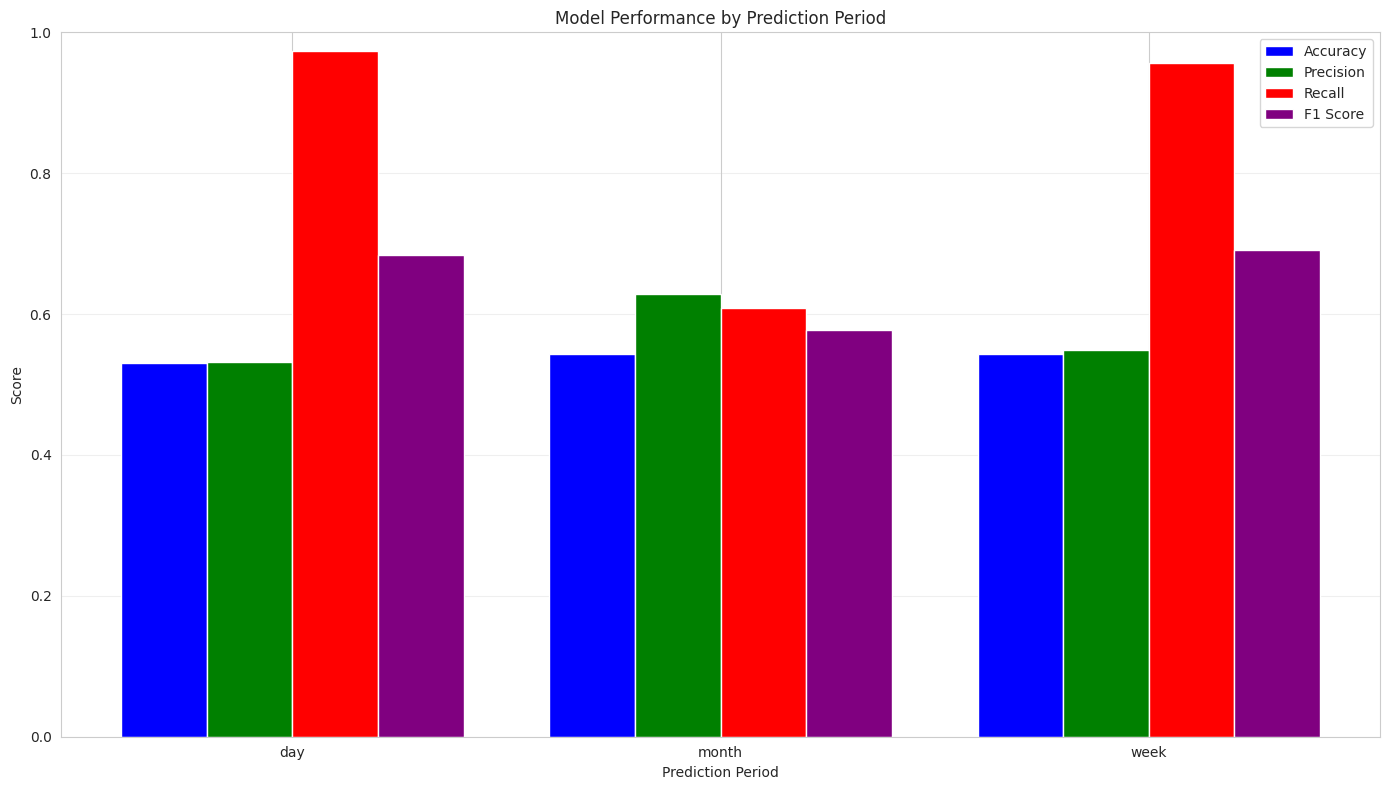


Top 5 Performing Models (by F1 Score):
IBM - month: F1=0.7920, Accuracy=0.6653
T - month: F1=0.7863, Accuracy=0.6493
GS - month: F1=0.7770, Accuracy=0.6353
V - week: F1=0.7643, Accuracy=0.6192
IBM - week: F1=0.7618, Accuracy=0.6152

Bottom 5 Performing Models (by F1 Score):
INTC - month: F1=0.2997, Accuracy=0.5130
NVDA - month: F1=0.4010, Accuracy=0.5331
V - month: F1=0.4560, Accuracy=0.4549
SPY - month: F1=0.4691, Accuracy=0.4830
NFLX - month: F1=0.4794, Accuracy=0.4429


In [45]:
def analyze_model_performance(results):
    """
    Analyze and visualize the performance of all trained models.
    
    Parameters:
    - results: Dictionary of results from train_all_models_parallel
    """
    # Create a DataFrame with performance metrics
    metrics_data = []
    
    for (stock, period), result in results.items():
        metrics = {
            'stock': stock,
            'period': period,
            'accuracy': result['best_metrics']['accuracy'],
            'precision': result['best_metrics']['precision'],
            'recall': result['best_metrics']['recall'],
            'f1': result['best_metrics']['f1'],
            'threshold': result['best_threshold'],
            'training_time': result['training_time']
        }
        
        if 'roc_auc' in result['best_metrics']:
            metrics['roc_auc'] = result['best_metrics']['roc_auc']
        
        metrics_data.append(metrics)
    
    metrics_df = pd.DataFrame(metrics_data)
    
    # Display summary statistics
    print("Summary of Model Performance:")
    for period in metrics_df['period'].unique():
        period_df = metrics_df[metrics_df['period'] == period]
        print(f"\n{period.capitalize()} Direction Prediction:")
        print(f"Number of models: {len(period_df)}")
        print(f"Average accuracy: {period_df['accuracy'].mean():.4f} (std: {period_df['accuracy'].std():.4f})")
        print(f"Average F1 score: {period_df['f1'].mean():.4f} (std: {period_df['f1'].std():.4f})")
        print(f"Average threshold: {period_df['threshold'].mean():.4f} (std: {period_df['threshold'].std():.4f})")
        print(f"Average training time: {period_df['training_time'].mean():.2f} seconds")
    
    # Visualize performance by period
    plt.figure(figsize=(14, 8))
    
    # Plot accuracy and F1 score by period
    period_metrics = metrics_df.groupby('period').agg({'accuracy': 'mean', 'f1': 'mean', 'precision': 'mean', 'recall': 'mean'}).reset_index()
    
    bar_width = 0.2
    x = np.arange(len(period_metrics))
    
    plt.bar(x - bar_width*1.5, period_metrics['accuracy'], width=bar_width, label='Accuracy', color='blue')
    plt.bar(x - bar_width/2, period_metrics['precision'], width=bar_width, label='Precision', color='green')
    plt.bar(x + bar_width/2, period_metrics['recall'], width=bar_width, label='Recall', color='red')
    plt.bar(x + bar_width*1.5, period_metrics['f1'], width=bar_width, label='F1 Score', color='purple')
    
    plt.xlabel('Prediction Period')
    plt.ylabel('Score')
    plt.title('Model Performance by Prediction Period')
    plt.xticks(x, period_metrics['period'])
    plt.ylim([0, 1])
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Top and bottom performing models
    top_models = metrics_df.sort_values('f1', ascending=False).head(5)
    bottom_models = metrics_df.sort_values('f1', ascending=True).head(5)
    
    print("\nTop 5 Performing Models (by F1 Score):")
    for i, row in top_models.iterrows():
        print(f"{row['stock']} - {row['period']}: F1={row['f1']:.4f}, Accuracy={row['accuracy']:.4f}")
    
    print("\nBottom 5 Performing Models (by F1 Score):")
    for i, row in bottom_models.iterrows():
        print(f"{row['stock']} - {row['period']}: F1={row['f1']:.4f}, Accuracy={row['accuracy']:.4f}")
    
    # Return the metrics DataFrame for further analysis
    return metrics_df

# Analyze model performance
performance_df = analyze_model_performance(all_results)

## 10. Visualize Best Models for Each Period


Visualizing top day model: V


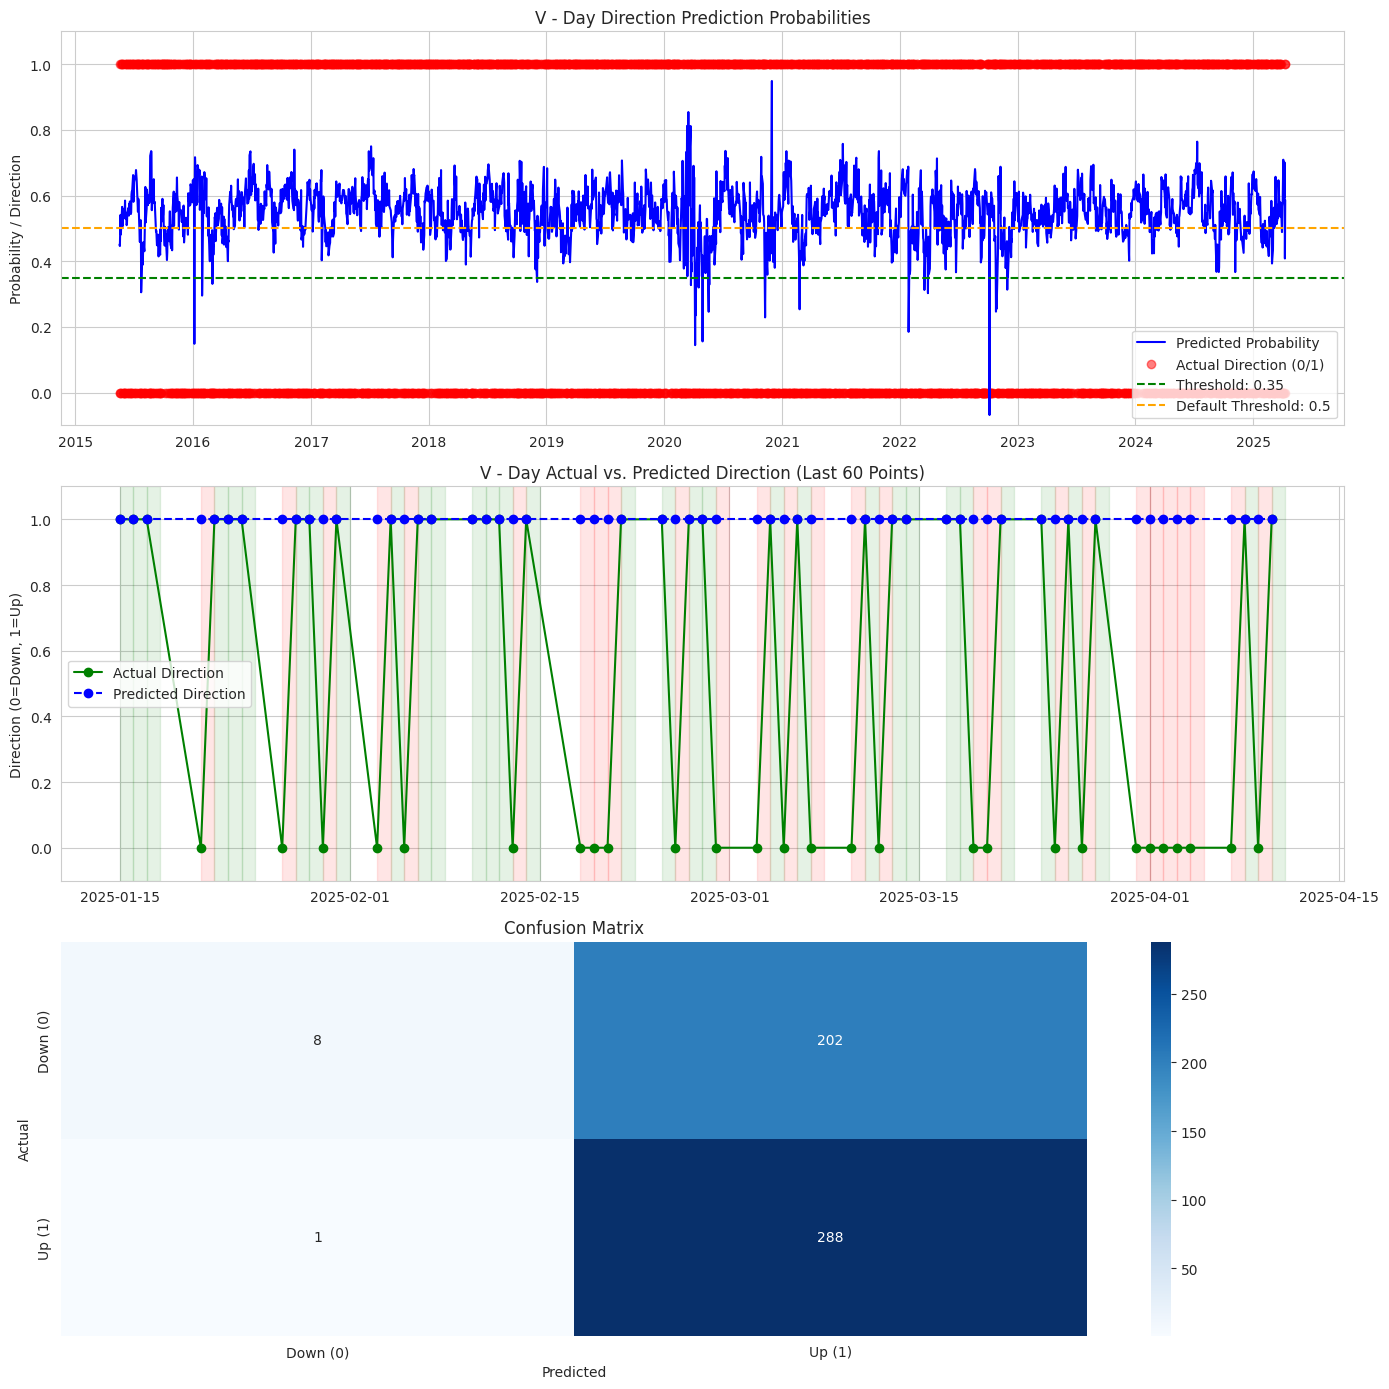


Prediction Statistics for V - Day:
Accuracy: 0.5932
F1 Score: 0.7394
Precision: 0.5878
Recall: 0.9965
ROC AUC: 0.4644

Class Distribution:
Down (0): 44.9%
Up (1): 55.1%

Visualizing top week model: V


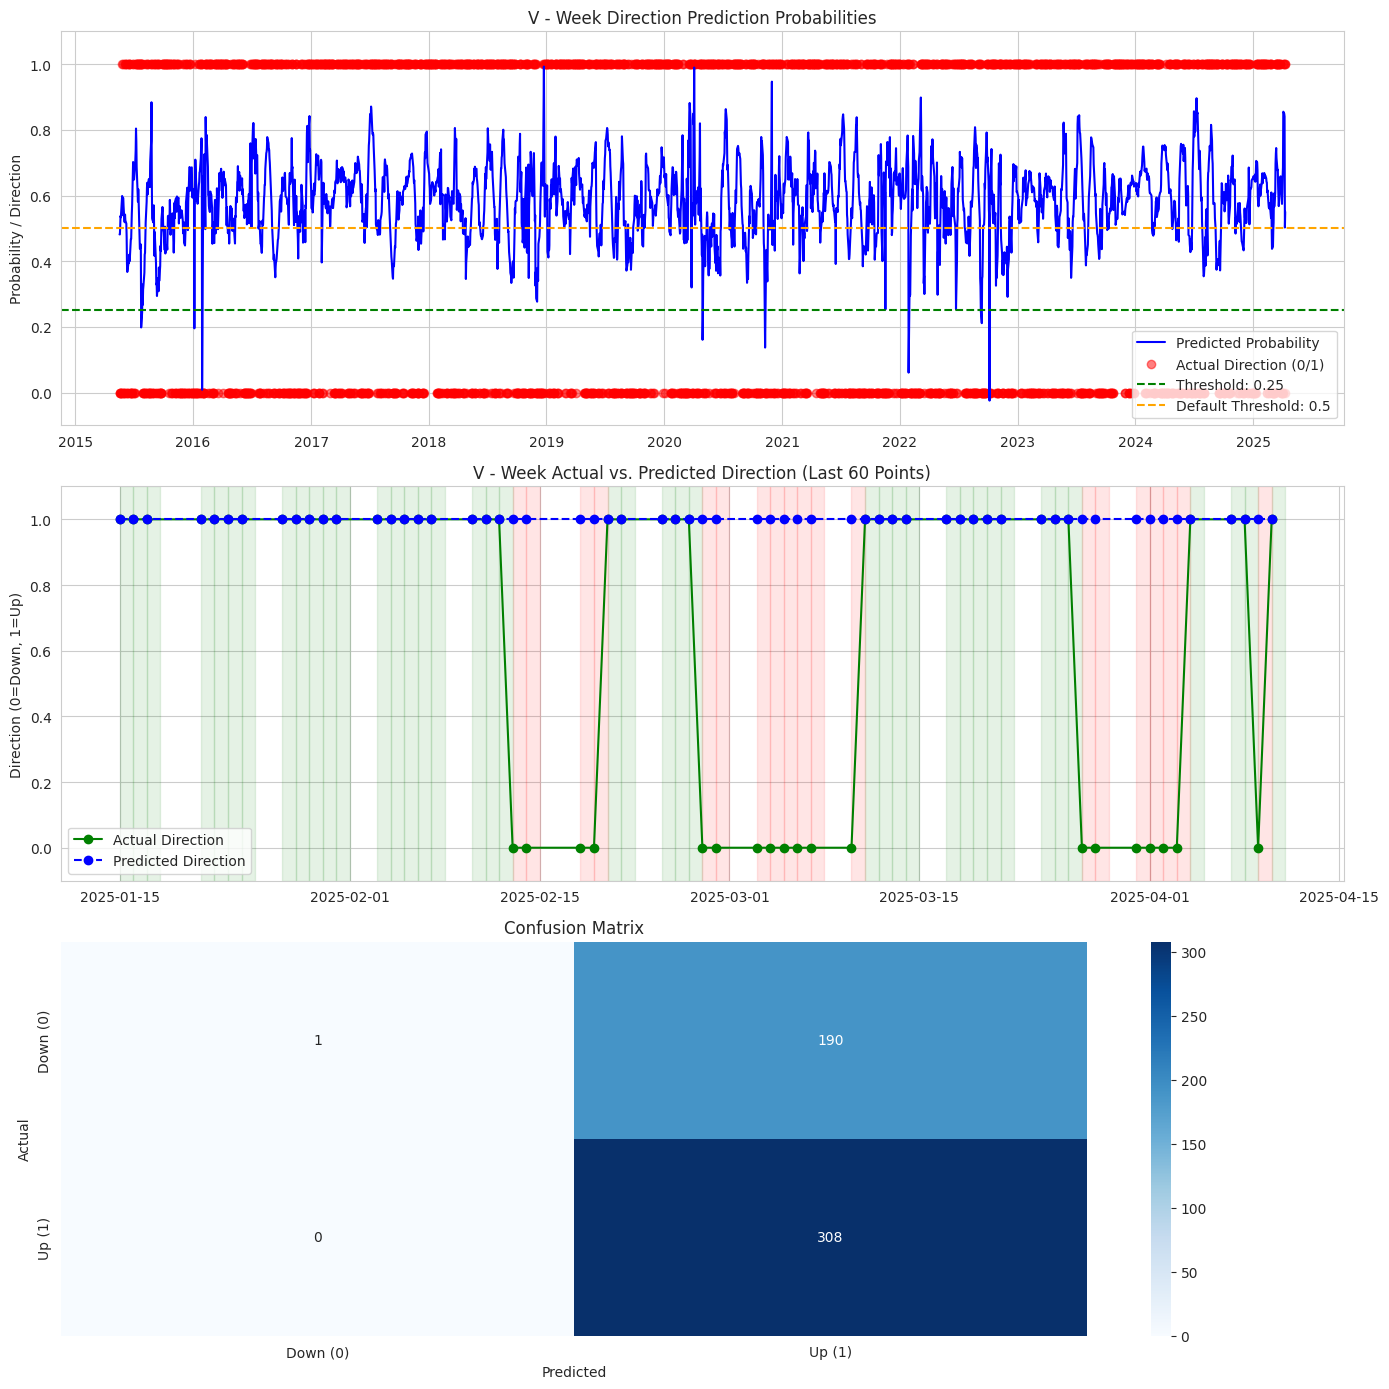


Prediction Statistics for V - Week:
Accuracy: 0.6192
F1 Score: 0.7643
Precision: 0.6185
Recall: 1.0000
ROC AUC: 0.4373

Class Distribution:
Down (0): 41.5%
Up (1): 58.5%

Visualizing top month model: IBM


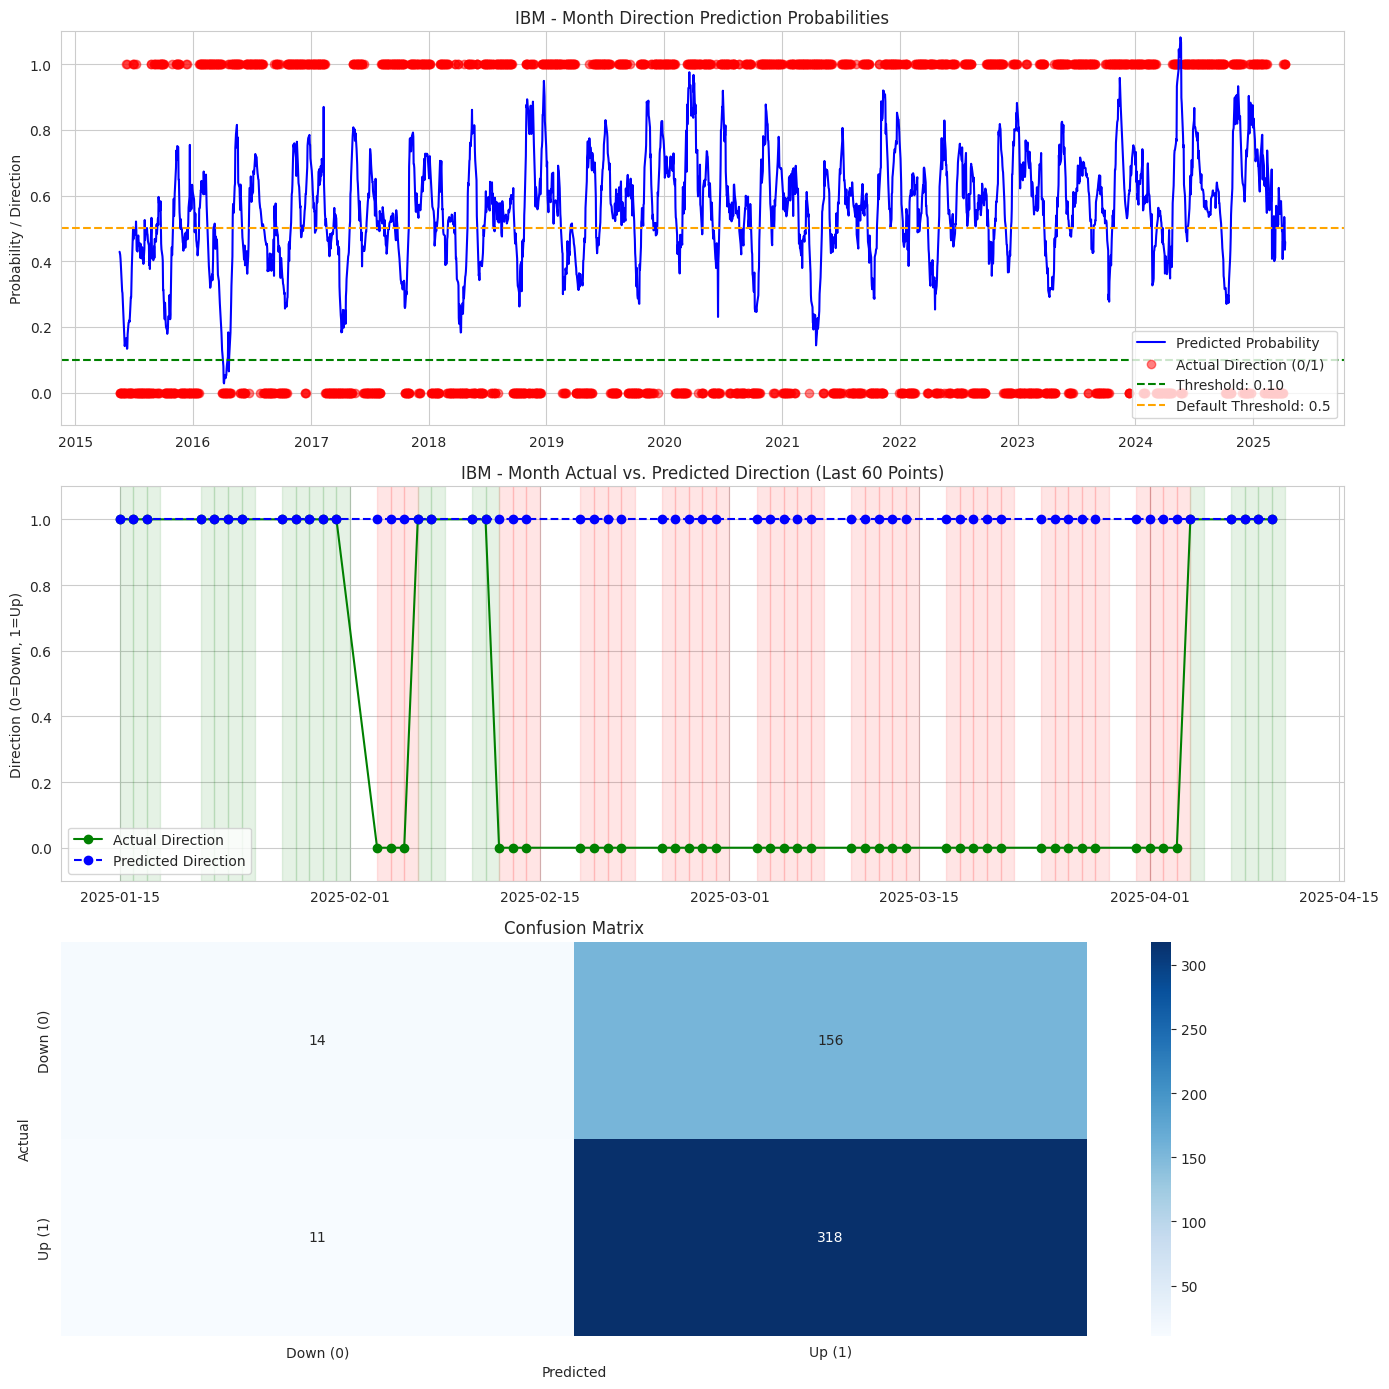


Prediction Statistics for IBM - Month:
Accuracy: 0.6653
F1 Score: 0.7920
Precision: 0.6709
Recall: 0.9666
ROC AUC: 0.5233

Class Distribution:
Down (0): 44.2%
Up (1): 55.8%


In [46]:
# Visualize predictions for the top performing model of each period
for period in periods:
    period_df = performance_df[performance_df['period'] == period]
    top_model = period_df.sort_values('f1', ascending=False).iloc[0]
    top_stock = top_model['stock']
    
    print(f"\nVisualizing top {period} model: {top_stock}")
    visualize_model_predictions(top_stock, period)